In [1]:
%load_ext autoreload

%autoreload 2

In [53]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.cluster import KMeans 
import itertools
import pulp
import cvxpy as cp
import pandas as pd 
from pytorch_grad_cam import (
    GradCAM, ScoreCAM, GradCAMPlusPlus,
    AblationCAM, XGradCAM, EigenCAM
)

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image
import numpy as np
import json
import cv2
import torch.nn.functional as F
from metrics.average_drop import AverageDrop
from metrics.average_increase import AverageIncrease
from metrics.compute_metrics import calculate_metrics
import os

In [27]:
# --- 1. Chuẩn bị model, CAM và preprocess pipeline ---
def get_resnet18(device="cpu"):
    model = models.resnet18(pretrained=True)
    model.eval().to(device)
    return model

_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

def preprocess_image(path, device="cpu"):
    img = Image.open(path).convert("RGB")
    return _preprocess(img).unsqueeze(0).to(device)

def get_cam(model, target_layer, method: str = "gradcam"):
    method = method.lower()
    cam_map = {
        "gradcam": GradCAM,
        "scorecam": ScoreCAM,
        "gradcam++": GradCAMPlusPlus,
        "ablationcam": AblationCAM,
        "xgradcam": XGradCAM,
        "eigencam": EigenCAM,
    }
    if method not in cam_map:
        raise ValueError(f"Unknown CAM method: {method}. Available: {list(cam_map.keys())}")
    CAMClass = cam_map[method]
    # Chỉ truyền model và target_layers
    return CAMClass(model=model, target_layers=[target_layer])

# --- 2. Lấy danh sách đường dẫn ảnh ---
def list_image_paths(image_dir):
    paths = []
    for root, _, files in os.walk(image_dir):
        for f in files:
            if f.lower().endswith((".jpg",".jpeg",".png")):
                paths.append(os.path.join(root, f))
    return sorted(paths)

# --- 3. Hàm chỉ lấy top-1 index cho mỗi ảnh ---
def predict_top1_indices(image_paths, model, device="cpu"):
    indices = []
    for p in image_paths:
        inp = preprocess_image(p, device)
        with torch.no_grad():
            out = model(inp)
            _, pred = out.max(1)
        indices.append(pred.item())
    return indices

# --- 4. Hàm chỉ tính grayscale CAM dựa vào top-1 index và đường dẫn ảnh ---
def compute_grayscale_cams(image_paths, cam, top1_indices, device="cpu"):
    cams = []
    for p, idx in zip(image_paths, top1_indices):
        inp = preprocess_image(p, device)
        # Không cần truyền use_cuda, CAM sẽ tự dùng device của model/input
        gcam_batch = cam(input_tensor=inp, targets=[ClassifierOutputTarget(idx)])
        cams.append(gcam_batch[0])
    return cams


In [16]:
# 6.1. Chọn GPU/CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# 6.2. Khởi tạo model và CAM
model = get_resnet18(device)
target_layer = model.layer4[-1]
method = "gradcam"  # hoặc "scorecam", "gradcam++", "ablationcam", "xgradcam", "eigencam"
cam = get_cam(model, target_layer, method=method)
print(f"Using CAM method: {method}")

# 6.3. Load ảnh & predict
image_dir = "datasets/imagenet"
paths = list_image_paths(image_dir)

top1_idxs = predict_top1_indices(paths, model, device=device)
print("Top-1 indices:", top1_idxs)

# 6.4. Tính CAM maps
cam_maps = compute_grayscale_cams(paths, cam, top1_idxs, device=device)
print(f"Computed {len(cam_maps)} CAM maps; each has shape {cam_maps[0].shape}")

# 6.5. (Tuỳ chọn) Stack thành array
cam_array = np.stack(cam_maps)  # shape (N, H, W)
print("CAM array shape:", cam_array.shape)

Using CAM method: gradcam
Top-1 indices: [0, 1, 2, 3, 842, 5, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 129, 22, 442, 24, 25, 32, 27, 28, 26, 30, 31, 32, 33, 34, 35, 36, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 49, 51, 52, 53, 54, 64, 58, 57, 20, 59, 53, 61, 62, 63, 64, 390, 59, 67, 68, 69, 70, 71, 72, 80, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 372, 105, 106, 711, 108, 390, 110, 111, 112, 113, 114, 115, 116, 117, 120, 119, 120, 121, 933, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 274, 160, 161, 162, 243, 164, 165, 166, 167, 168, 222, 170, 171, 172, 173, 248, 202, 176, 177, 178, 179, 180, 181, 182, 183, 207, 185, 186, 187, 188, 189, 190, 184, 192, 187, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 182, 205, 221, 207, 208, 209, 210, 211, 212

In [18]:
threashold =  0.3

In [28]:
def visualize_cam_on_image(img_path, model, cam, device="cpu"):
    # 1) Load ảnh gốc RGB [0,1], giữ kích thước gốc
    orig_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    orig_rgb = orig_bgr[:, :, ::-1].astype(np.float32) / 255.0

    # 2) Load PIL + preprocess để tạo tensor 224×224
    pil = Image.open(img_path).convert("RGB")
    input_tensor = _preprocess(pil).unsqueeze(0).to(device)

    # 3) Predict để lấy top-1 class index
    with torch.no_grad():
        out = model(input_tensor)
        _, pred = out.max(1)
        target_idx = pred.item()

    # 4) Tính grayscale CAM (shape 224×224)
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=[ClassifierOutputTarget(target_idx)])[0]

    # 5) Resize ảnh gốc về 224×224 để overlay
    h, w = grayscale_cam.shape
    resized_rgb = cv2.resize(orig_rgb, (w, h), interpolation=cv2.INTER_LINEAR)

    # 6) Overlay và hiển thị
    cam_overlay = show_cam_on_image(resized_rgb, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(5,5))
    plt.imshow(cam_overlay)
    plt.axis("off")
    plt.title(f"Class {target_idx}")
    plt.show()

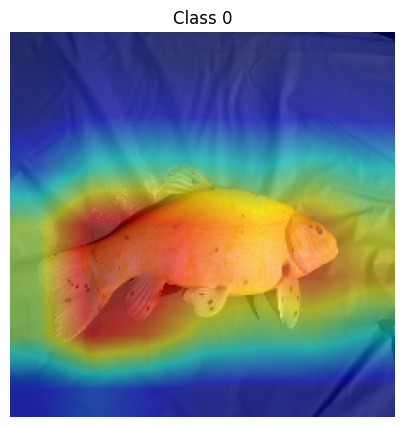

In [29]:
img_path = "datasets/imagenet/n01440764_tench.JPEG"
visualize_cam_on_image(img_path, model, cam, device=device)

In [33]:
# 1. Lấy đường dẫn ảnh
paths = list_image_paths(image_dir)

# 2. Tạo list các tensor [1,3,224,224]
preprocessed_images = [
    preprocess_image(p, device) for p in paths
]

# 3. Compute top1_indices & cam_maps như trước
top1_indices = predict_top1_indices(paths, model, device=device)
cam_maps        = compute_grayscale_cams(paths, cam, top1_indices, device=device)

# 4. Giờ mới zip để tính metrics
average_drops = []
increase_confidences = []


In [35]:
for img_tensor, saliency_map, target_cls in zip(
        preprocessed_images, cam_maps, top1_indices
    ):
    drop, inc = calculate_metrics(
        model=model,
        image=img_tensor,
        saliency_map=saliency_map,
        target_class=target_cls,
        threshold=0.5
    )
    average_drops.append(drop)
    increase_confidences.append(inc)

In [39]:
drops_array = np.array(average_drops)
incs_array  = np.array(increase_confidences)

# 2) Tính mean
mean_drop     = drops_array.mean()
mean_inc_conf = incs_array.mean()*100

print(f"Mean Average Drop: {mean_drop:.4f}%")
print(f"Mean Increase-in-Confidence: {mean_inc_conf:.4f}%")

Mean Average Drop: 46.2416%
Mean Increase-in-Confidence: 12.8000%


# Function defines 

Sử dụng K-means để phân cụm các feature maps có độ tương đồng lớn 

In [41]:
# co the su dung global average pooling cho moi feature map 
# hien tai dang chuyen thanh vector 1 chieu 

def group_feature_maps(
    list_feature_maps: torch.Tensor | np.ndarray,
    number_of_clusters: int,
    ) -> list[tuple[int, ...]]:
    
    """
    Args:
        list_feature_maps (torch.Tensor or np.ndarray):
        Tensor or array of feature maps with shape (C, H, W) or (C, H*W).
        number_of_clusters (int): number of clusters to form.

    Returns:
        list[tuple[int, ...]]: Each tuple contains the channel indices in one cluster.
    """
    if not isinstance(number_of_clusters, int):
        raise ValueError("number of clusters must be an integer")
    
    # Convert to numpy array if torch.Tensor
    if isinstance(list_feature_maps, torch.Tensor):
        data = list_feature_maps.detach().cpu().numpy()
    else:
        data = list_feature_maps
    
    # Determine number of channels
    C = data.shape[0]
    if number_of_clusters < 1 or number_of_clusters > C:
        raise ValueError(
            f"number_of_clusters must be between 1 and {C}, got {number_of_clusters}"
        )
        
    
    # Flatten spatial dimensions (H, W) into feature vector
    flattened = data.reshape(C, -1)  # shape: (C, H*W)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=0)
    labels = kmeans.fit_predict(flattened)
    
    # Build clusters of indices
    groups: list[tuple[int, ...]] = []
    for cluster_idx in range(number_of_clusters):
        idxs = tuple(int(i) for i in np.where(labels == cluster_idx)[0])
        groups.append(idxs)

    return groups

In [42]:
def get_feature_maps(
    model: nn.Module,
    input_tensor: torch.Tensor,
    target_module: nn.Module,
    ) -> list[torch.Tensor]:
    
    """
    Args:
        model (nn.Module): PyTorch model.
        input_tensor (torch.Tensor): Input tensor of shape (N, C, H, W).
        target_layers (list[nn.Module]): List of layers to extract feature maps from.
    """
    feature_maps = None
    
    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output.detach().cpu()
        return output
    # Register the forward hook on the target_module
    hook = target_module.register_forward_hook(hook_fn)
    _ = model(input_tensor)
    hook.remove()
    
    if feature_maps is None:
        raise ValueError("Cannot extract feature maps from target_module.")
    
    return feature_maps
    
    

In [43]:
def group_last_conv_feature_maps(
    model: nn.Module,
    input: torch.Tensor,
    target_module: nn.Module,
    number_of_clusters: int,
    ) -> list:
    
    """ 
    Group the feature maps of the last convolutional layer of a model using KMeans clustering.
    Args:
        model (nn.Module): model to run the forward pass on
        input (torch.Tensor): input to the model 
        target_module (nn.Module): module to get the feature maps from
        number_of_clusters (int): number of clusters to form 
    Returns: Nhóm các chỉ số của các feature maps ví dụ [(0, 1), (2, 3), (4, 5)]; (0, 1) là cụm 1
    """
    feature_maps = None 
    
    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output.detach().cpu()
        return output
    # Register the forward hook on the target_module
    hook = target_module.register_forward_hook(hook_fn)
    _ = model(input)
    hook.remove()
    
    if feature_maps is None:
        raise ValueError("Cannot extract feature maps from target_module.")
    
    n_feature_maps = feature_maps.shape[1]  # C
    groups = group_feature_maps(feature_maps[0], number_of_clusters) #(1, C, H, W) => (C, H, W)
    
    return n_feature_maps, groups

In [44]:
target_module = model.layer4[-1]

In [46]:
# n_feature_maps, groups = group_last_conv_feature_maps(model, input_tensor, target_module, number_of_clusters=15)

Che feature maps xác định bằng 0 và tính toán output của model

In [47]:
def do_masked_forward( model: nn.Module, 
                    input: torch.Tensor,
                    target_module: nn.Module,
                    mask_indices: list | torch.Tensor,
                    mask_value: float = 0.0,
                    ) -> torch.Tensor:
    
    """
    Run a forward pass through a model while masking specific channels in the output for a target module. 
    This is useful for analyzing the contribution of specific channels to the model's output.
    Args:
        model (nn.Module): model to run the forward pass on
        input (torch.Tensor): input to the model 
        mask_indices (list | torch.Tensor): indices of channels to mask
        mask_value (float, optional): Defaults to 0.0.
    """
    def hook_fn(module, input, output):
        # Mask the specified channels in the output
        device = output.device  # Lấy device của output (CPU hoặc GPU)
    
        if isinstance(mask_indices, list):
            idx = torch.tensor(mask_indices, dtype=torch.long, device=device)
        else:
            idx = mask_indices.to(dtype=torch.long, device=device)

        if output.dim() >= 2:  # (N, C, H, W) hoặc (N, C)
            # print(f"Idx: {idx}")
            output[:, idx, ...] = mask_value
    
    # Register the forward hook on the target_module
    hook = target_module.register_forward_hook(hook_fn)
    
    # Run the forward pass through the entire model
    out = model(input)
    
    # Remove the hook
    hook.remove()
    return out
    

In [ ]:
# mask_indices = [1, 20, 30]
# mask_indices = [0,1,2,5] 

In [ ]:
# output = do_masked_forward(model, x, target_module, mask_indices, mask_value=0.0)
# print("Output shape:", output.shape)

Tính contributions của từng nhóm 

In [48]:
def value_func(coalition: list[tuple[int, ...]],
                model: nn.Module,
                input: torch.Tensor,
                target_module: nn.Module,
                n_channels: int,
                target_class: int,
                mask_value: float = 0.0,
                ) -> float: 
    """
    Tính đóng góp của coalition dựa trên đầu ra của model. Các kênh không thuộc coalition sẽ bị mask bằng giá trị 0.0.
    Args:
        coalition (list):  Danh sách các nhãn nhóm (group labels) được giữ bật (unmasked). Ví dụ coalition = [(0, 1), (2, 3)]
        model (nn.Module): CNN model 
        input (torch.Tensor): ảnh đầu vào (B, C, H, W)
        target_module (nn.Module): lớp conv mà feature maps được trích xuất
        n_channels: số lượng kênh trong feature map
        target_class (int): class mục tiêu để tính toán đóng góp 
    """
    # 1) flatten toàn bộ channel trong coalition
    unmask = set()
    for group in coalition:
        unmask.update(group)
        
    # 2) danh sách các channel phải mask = những c ∉ unmask
    mask_indices = [c for c in range(n_channels) if c not in unmask]
    # print(f"Masking channels: {mask_indices}")
   
    # 3) chạy forward với hook
    with torch.no_grad():
        output = do_masked_forward(model, input, target_module, mask_indices, mask_value)
        probs = torch.nn.functional.softmax(output[0], dim=0)
    
    # top5 = torch.topk(probs, 5)
    # print("Top-5 class indices and probabilities:")
    # for idx, p in zip(top5.indices.tolist(), top5.values.tolist()):
    #     print(f"Class {idx}: {p:.4f}")
        
    # 4) trả về logit/score cho target_class
    target_output = float(probs[target_class].item())
    
    return target_output

In [50]:
def compute_group_contributions(
    model: nn.Module,
    input: torch.Tensor,
    target_module: nn.Module,
    number_of_clusters: 10,
    target_class: int = 281,
    mask_value: float = 0.0,
):
    """
    Solve for the nucleolus allocation x ∈ R^G over G groups of feature‐maps.
    
    Args: 
        model: DNN model
        input: Ảnh đầu vào 
        target_module: Lớp tích chập extract feature maps
        number_of_clusters: số lượng nhóm kênh 
        target_class: class mục tiêu để tính toán đóng góp
        mask_value: giá trị để mask các kênh không thuộc coalition, default = 0 
    Returns:
      x_opt: ndarray of shape (G,)
      epsilon_opt: the minimized maximum excess

    """
    # 1) group feature maps
    n_channels , groups = group_last_conv_feature_maps(model, input, target_module, number_of_clusters) #e.g: groups = [(0, 1), (2, 3), (4, 5)]
    print("Groups:", groups)
    # Số lượng kênh 
    G = len(groups)

    # 2) Tính v(S) cho mỗi coalition S (tập tuple group indices) ⊂ {0,…,G−1}
    coalitions = []
    for r in range(1, G+1):
        for combo in itertools.combinations(range(G), r):
            coalition = [groups[i] for i in combo]
            coalitions.append((combo, coalition))
    # Bao gồm full coalition
    full_idx = tuple(range(G))
    

    # Tính v cho từng coalition
    v: dict[tuple[int, ...], float] = {} # {"(0,1)": 0.5, "(2,3)": 0.3}
    v[full_idx] = value_func(groups, model, input, target_module, n_channels, target_class , mask_value)
    print("v(full_idx):", v[full_idx])
    for idxs, coalition in coalitions:
        if idxs != full_idx:
            v[idxs] = value_func(coalition, model, input, target_module, n_channels, target_class, mask_value)
    
    records = [
        {"coalition": str(coal), "value": val}
        for coal, val in v.items()
    ]
    df = pd.DataFrame(records)
    csv_path = "/home/infres/xnguyen-24/XAI/results/coalition_values.csv"
    df.to_csv(csv_path, index=False)
    print(f"Coalition values saved to {csv_path}")
            

   # 3) Khởi tạo biến CVXPY
    x = cp.Variable(G)
    eps = cp.Variable()
    cons = [cp.sum(x) == v[full_idx], x >= 0, eps >= 0]
    for S, val in v.items():
        if S != full_idx:
            cons.append(cp.sum(x[list(S)]) >= val - eps)

    prob = cp.Problem(cp.Minimize(eps), cons)
    prob.solve(solver=cp.SCS)
    if prob.status not in (cp.OPTIMAL, "optimal"):
        raise RuntimeError(f"LP did not solve: {prob.status}")
    
    group_contributions = [ {"group": groups[i], "contribution": float(x.value[i])} for i in range(G)]
    
    return x.value, eps.value,  group_contributions


In [51]:
def compute_group_representatives(
    feature_maps: torch.Tensor, 
    groups: list[tuple[int, ...]]) -> torch.Tensor:
    """
    Tính đại diện cho mỗi nhóm feature maps bằng cách lấy trung bình các kênh.
    
    Args:
        feature_maps (torch.Tensor): Tensor có shape (C, H, W) với C là số kênh.
        groups (list[tuple[int, ...]]): Danh sách các tuple chứa chỉ số các kênh cho mỗi nhóm.
    
    Returns:
        torch.Tensor: Tensor có shape (G, H, W), với G là số nhóm.
    """
    representatives = []
    for group in groups:
        # Lấy các feature map theo chỉ số trong group và tính trung bình theo kênh
        group_maps = feature_maps[list(group)]  # shape: (len(group), H, W)
        rep = group_maps.mean(dim=0)  # shape: (H, W)
        representatives.append(rep)
    return torch.stack(representatives, dim=0)  # shape: (G, H, W)

In [52]:
def compute_weighted_group_representatives(
    feature_maps: torch.Tensor, 
    groups: list[tuple[int, ...]],
    contributions: list[float]
) -> torch.Tensor:
    """
    Tính weighted representatives cho mỗi nhóm bằng cách nhân đại diện (tính theo trung bình)
    với trọng số contribution của nhóm đó.
    
    Args:
        feature_maps (torch.Tensor): Tensor có shape (C, H, W) với C là số kênh.
        groups (list[tuple[int, ...]]): Danh sách các tuple chứa chỉ số các kênh cho mỗi nhóm.
        contributions (list[float]): Danh sách contribution tương ứng với mỗi nhóm.
        
    Returns:
        torch.Tensor: Tensor có shape (G, H, W), với G là số nhóm.
    """
    if len(groups) != len(contributions):
        raise ValueError("Độ dài của groups và contributions phải bằng nhau.")
        
    weighted_reps = []
    for group, weight in zip(groups, contributions):
        group_maps = feature_maps[list(group)]    # shape: (len(group), H, W) -> lấy feature maps theo chỉ số trong group
        rep = group_maps.mean(dim = 0) # tính trung bình theo kênh , shape (H , W)
        weighted_rep = weight * rep                 # tính weighted representative
        weighted_reps.append(weighted_rep)
    return torch.stack(weighted_reps, dim=0)        # shape: (G, H, W)